# 

In [3]:
# %load_ext line_profiler
import numpy as np
import matplotlib.pyplot as plt
import scipy
from scipy.sparse import spdiags, kron, eye, linalg
from scipy.sparse.linalg import  spsolve
n_run = 1

In [4]:
def A_matrix(n):
    ones = np.ones(n-1);
    T = spdiags([-ones,8*ones,-ones], [-1,0,1])
    S = spdiags([ones, ones, ones], [-1,0,1])
    return 3*n*kron(eye(n-1), T) - 3*n*kron(spdiags([ones, ones], [-1, 1]), S)

def M_matrix(n):
    ones = np.ones(n-1);
    Q = spdiags([ones, 4*ones, ones], [-1,0,1])
    return 1/n*kron(Q, Q/4)

In [5]:
def problem_2_solve(n):
    print(f"Debug: Solving problem 1 for n={n}")
    A = A_matrix(n).tocsc()
    M = M_matrix(n)


    x = y = np.arange(1,n) / n
    X, Y = np.meshgrid(x,y)

    f = 5 * np.pi**2 * np.sin(2*np.pi*X)*np.sin(np.pi*Y)
    b = f.reshape(((n-1)**2, 1))
    
    prod = M.dot(b)
    return linalg.spsolve(A, prod), (X,Y)

ns = [4,8,16,32,64]
us = [ problem_2_solve(n) for n in ns ]

Debug: Solving problem 1 for n=4
Debug: Solving problem 1 for n=8
Debug: Solving problem 1 for n=16
Debug: Solving problem 1 for n=32
Debug: Solving problem 1 for n=64


In [13]:
def phi_eval(x,k,n):
    return (k-1 < x*n)*(x*n < k  )* (1 - k + x*n) \
        +  (k   < x*n)*(x*n < k+1)* (1 + k - x*n)

N = 0 # A counter to check how many times the function is called as a callback
def u_eval(x,y,U,i,j,n):
    global N
    N = N + 1
    I, J = np.meshgrid([i,i+1],[j, j+1])
    mask = (I > 0) * (I < n) * (J > 0) * (J < n)
    I = I[mask]
    J = J[mask]
    
    values = phi_eval(x,I,n)*phi_eval(y,J,n)
    values = values * U[(J-1)*(n-1) + (I-1)]
    return np.sum(values)

# Test values
# i,j = 16,16
# u_eval((2*i + 1)/(2*ns[n_run]),(2*j + 1)/(2*ns[n_run]),us[n_run][0],i,j,ns[n_run])
# %lprun -f u_eval u_eval((2*i + 1)/(2*ns[n_run]),(2*j + 1)/(2*ns[n_run]),us[n_run][0],i,j,ns[n_run])
def phi_grad_eval(x,k,n):
    return (k-1 < x*n)*(x*n < k  )* n \
        +  (k   < x*n)*(x*n < k+1)* (-n)

In [14]:
def u_grad_eval(x,y,u,i,j,n):
    I, J = np.meshgrid([i,i+1],[j, j+1])
    mask = (I > 0) * (I < n) * (J > 0) * (J < n)
    I = I[mask]
    J = J[mask]
    U = u[(J-1)*(n-1) + (I-1)]
    
    x_values = U * phi_grad_eval(x,I,n)*phi_eval(y,J,n)
    y_values = U * phi_eval(x,I,n)*phi_grad_eval(y,J,n)
    return np.array([np.sum(x_values), np.sum(y_values)])
   

i = j = ns[n_run]//2

 
u_grad_eval((2*i + 1)/(2*ns[n_run]),(2*j + 1)/(2*ns[n_run]),us[n_run][0],i,j,ns[n_run])

array([-5.20975691,  0.20612992])

In [15]:
import itertools

def u(x,y):
    return np.sin(2*np.pi*x)*np.sin(np.pi*y)
def u_grad(x,y):
    return np.pi*np.array([2*np.cos(2*np.pi*x)*np.sin(np.pi*y),
                           np.sin(2*np.pi*x)*np.cos(np.pi*y)])
def error_computation(n,U,):
    for i,j in itertools.product(range(1,n), range(1,n)):
        (u(x,y) - u_eval(x,y,U,i,j))**2

In [45]:
def L2_error_fun(y, x, U, n, i, j):
    return (u(x,y) - u_eval(x,y,U,i,j, n))**2

def H1_error_fun(y, x, U, n, i, j):
    return np.sum((u_grad(x,y) - u_grad_eval(x, y, U, i, j, n))**2)


def total_error(U,n,error_fun):     
    default_error = 1.49e-8

    def L2_norm(i, j):
        x_low, y_low = i/n, j/n
        h = 1/n
        result = scipy.integrate.dblquad(error_fun, x_low, 
                                         x_low + h, y_low, 
                                         y_low + h, 
                                         args = (U, n, i, j), 
                                         epsabs = 1.49e-9)[0]
        return result

    mesh_tuples = itertools.product(range(0,n), range(0,n))

    ## Multi-threaded solution. About the same speed unfortunately
    import concurrent.futures as futures
    with futures.ThreadPoolExecutor() as executor:
        futures = [ executor.submit(L2_norm, i,j) for (i,j) in mesh_tuples ]
        integrals = [ f.result() for f in futures ]

    ## One thread
    # integrals = [ L2_norm(i,j)  for (i,j) in mesh_tuples ]) ]
       
    return np.sqrt(np.sum(np.array(integrals)))

from datetime import datetime
for i in range(3):
    T = datetime.now()
    print("Iteration %i" % i)
    print("L2- rr:", total_error(us[i][0],ns[i],L2_error_fun))
    print("Time elapsed: ", datetime.now() - T)
    T = datetime.now()
    print("H1-rr:", total_error(us[i][0],ns[i],H1_error_fun))
    print("Time elapsed: ", datetime.now() - T)
    print()

Iteration 0
L2- rr: 0.1792788455180071
Time elapsed:  0:00:01.138771
H1-rr: 1.5991101578363316
Time elapsed:  0:00:01.863956

Iteration 1
L2- rr: 0.05246993478170824
Time elapsed:  0:00:04.425147
H1-rr: 0.7604975029470463
Time elapsed:  0:00:07.164349

Iteration 2
L2- rr: 0.01363765058636007
Time elapsed:  0:00:17.534408
H1-rr: 0.3707808121100696
Time elapsed:  0:00:28.886324



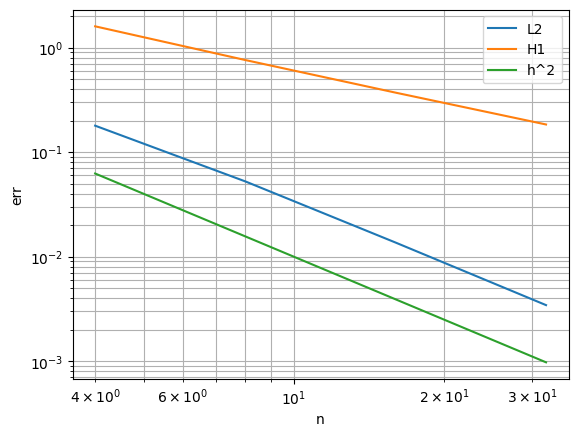

In [46]:
values = np.array([[ 0.1792788455180071, 1.5991101578363316],
[ 0.05246993478170822, 0.7604975029470463],
[0.013637650586360062, 0.3707808121100696],
[0.00344259714549818,0.18402302784684987]])

plt.loglog(ns[0:4], values[:,0], label='L2')
plt.loglog(ns[0:4], values[:,1], label='H1')
plt.loglog(ns[0:4], 1/(np.array(ns[0:4])**2), label='h^2')
plt.xlabel('n')
plt.ylabel('err')
plt.grid(True, which="both")
plt.legend()